<div style='color:white;font-size:30px;background-color:#196363;text-align:center;padding-top:20px; padding-bottom:20px;margin-bottom:40px'>VERSIFICATION & AUTHORSHIP ATTRIBUTION</div>
<h1>3.3.1 Lexical based (fine-tuuning)</h1>
<h2 style='margin-bottom: 50px'>Replication code</h2>
<p>
<div style='color:red; font-weight:bold'>WARNING: This script comprises tens of thousands of iterations and takes ages to finish</div>

In [3]:
import json
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
import sticho
from collections import defaultdict
from multiprocessing import Manager, Pool
from scipy import stats
from sklearn.svm import SVC

<h3>Read data from JSON</h3>

In [4]:
#----------------------------------------------------------------------------------------------------------#
# Files contain a list of poems with following structure:                                                  #   
# [{                                                                                                       #
#    'author': string (name of the author),                                                                #
#    'title': string (title of the poem),                                                                  #
#    'subcorpus': int (id of the subcorpus to which the poem belongs)                                      #
#    'body': [{                                                                                            #
#        'rhyme': empty list (just to make it compatible with sticho package)                              #
#        'words': [{                                                                                       #
#            'token': string,                                                                              #
#            'lemma': string,                                                                              #
#         }, ...]                                                                                          #
#     }, ... ]                                                                                             #
# }, ...]                                                                                                  #
#                                                                                                          #
# CZECH CORPUS                                                                                             #
# Dataset comes from The Corpus of Czech Verse (http://versologie.cz/v2/web_content/corpus.php?lang=en).   #
#                                                                                                          #
# SPANISH CORPUS                                                                                           #
# Dataset comes from Corpus de Sonetos del Siglo de Oro                                                    #
#    (https://github.com/bncolorado/CorpusSonetosSigloDeOro).                                              #
# Tokenization, lemmatization, pos-tagging provided by TreeTagger                                          #
#    (https://www.cis.uni-muenchen.de/~schmid/tools/TreeTagger/).                                          #
# Phonetic transcription provided by ESpeak (http://espeak.sourceforge.net/)                               #
#                                                                                                          #
# GERMAN CORPUS                                                                                            #
# Dataset not published here as it comes from proprietary corpus Metricalizer (http://metricalizer.de).    #
#----------------------------------------------------------------------------------------------------------#

data = dict()

with open('data/cs_control1.json', 'r') as f: # Czech corpus is split into two files to maintain 100MB limit
    data['cs'] = json.load(f)
with open('data/cs_control2.json', 'r') as f:
    data['cs'].extend(json.load(f))

with open('data/es.json', 'r') as f:
    data['es'] = json.load(f)
    
# Subcorpora available for each corpus
subcorpora = {'cs': (1,2,3), 'es': (1,2)}

<h3>Number of samples per author</h3>

In [4]:
# Iterate over subcorpora
for lang in sorted(data):
    for subc in subcorpora[lang]:
        # Extract samples and print the number per author
        s = sticho.Sampler(data[lang], n=100, subcorpus=subc, min_rhymes=0)
        print('='*30, '{0}{1}'.format(lang, subc), '='*30)
        for a in sorted(s.samples_):
            print('{0} ({1})'.format(a, len(s.samples_[a])))

============================== cs1 ==============================
Burgerstein, Josef (11)
Chmelenský, Josef Krasoslav (18)
Erben, Karel Jaromír (20)
Furch, Vincenc (40)
Hajniš, František (42)
Jablonský, Boleslav (18)
Jungmann, Josef (21)
Kamarýt, Josef Vlastimil (34)
Klácel, František Matouš (59)
Kollár, Jan (102)
Koubek, Jan Pravoslav (34)
Langer, Josef Jaroslav (30)
Macháček, Simeon Karel (27)
Marek, Jan Jindřich (27)
Mácha, Karel Hynek (31)
Nebeský, Václav Bolemír (20)
Polák, Milota Zdirad (19)
Puchmajer, Antonín Jaroslav (41)
Rokos, František Alexandr (20)
Rubeš, František Jaromír (35)
Ryba, Jakub Jan (16)
Ráb, Václav Věnceslav (16)
Sabina, Karel (14)
Stach, Václav (32)
Sušil, František (103)
Sychra, Matěj Josef (13)
Thám, Václav (13)
Tomíček, Jan Slavomír (19)
Vacek Kamenický, František Jaroslav (38)
Villani, Karel Maria Drahotín (16)
Wenzig, Josef (29)
Štulc, Václav (28)
============================== cs2 ==============================
Adámek, Bohumil (12)
Ambrož, Vilém (21)
Baše

<h3>Cross-validation</h3>

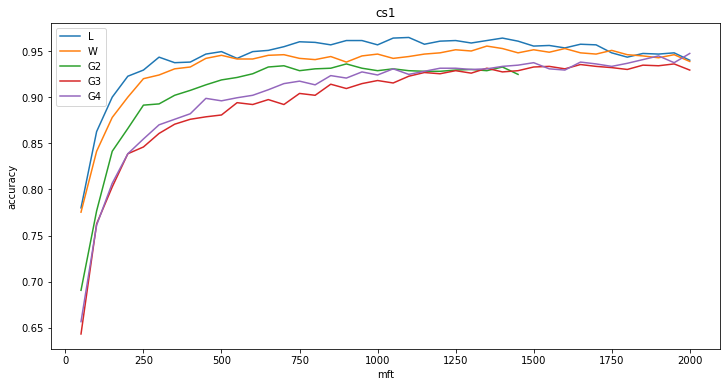

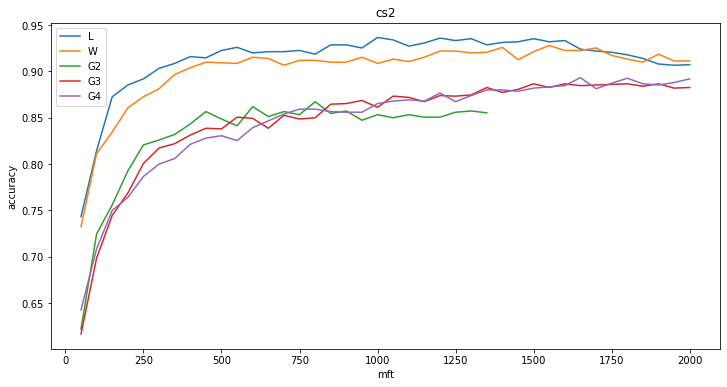

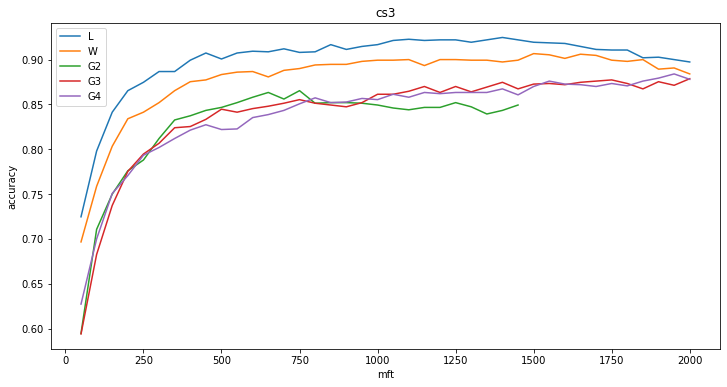

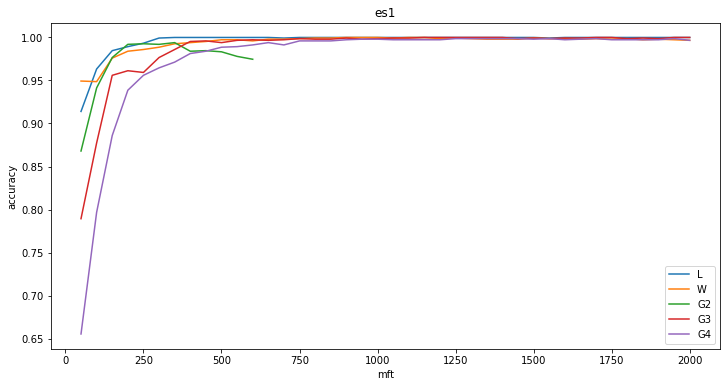

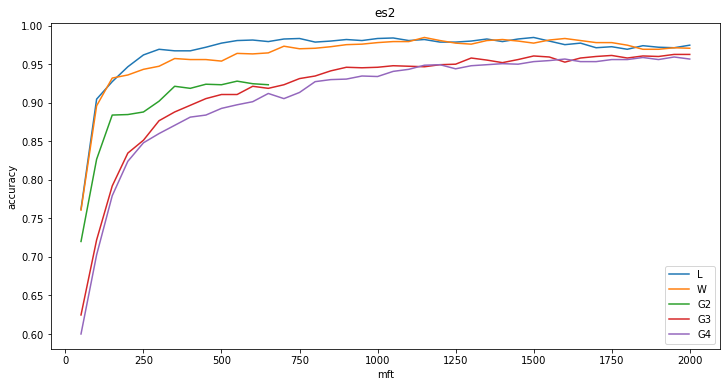

In [11]:
mft_levels = [ i*50 for i in range(1,41) ]
iterations = 30

# Container to store results
results = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

# Get number of possible bigrams in each subcorpus
max_bigrams = defaultdict(dict)
for lang in data:
    for subc in subcorpora[lang]:
        s = sticho.Sampler(data[lang], n=100, subcorpus=subc, min_rhymes=0)
        f = sticho.Features(s)
        f.char_ngrams(n=2, mft=0)
        f.build_dataframe()
        max_bigrams[lang][subc] = len(f.df_.columns)

# Iterate over subcorpora
for lang in data:
    for subc in subcorpora[lang]:
        # Perform 30 iterations
        for iteration in range(iterations):            
            
            # SAMPLING
            s = sticho.Sampler(data[lang], n=100, subcorpus=subc, min_rhymes=0)
            # Select 5 authors by random
            s.level_authors(n=5)
            # Randomly select 10 samples by each author
            s.level_samples(max_=10) 

            # Iterate over different settings of most frequent types
            for mft in [ i*50 for i in range(1,41) ]:
           
                print('iteration #{0} | mft = {1} | lang = {2} | subc = {3}              '.format(
                    iteration+1, mft, lang, subc
                ), end='\r')           
                
                # CLASSIFICATION WITH LEMMATA
                f = sticho.Features(s)
                f.bow(domain='lemma', mft=mft)
                f.build_dataframe()
                # Cross-validation
                c = sticho.Classification(f, clf='svm', kernel='linear', C=1)
                results[lang+str(subc)]['L'][mft] += c.cross_validation() / iterations

                # CLASSIFICATION WITH WORDS
                f = sticho.Features(s)
                f.bow(domain='word', mft=mft)
                f.build_dataframe()
                # Cross-validation
                c = sticho.Classification(f, clf='svm', kernel='linear', C=1)
                results[lang+str(subc)]['W'][mft] += c.cross_validation() / iterations

                # CLASSIFICATION WITH CHARACTER N-GRAMS
                for n in (2,3,4):
                    # Skip if number of bigrams exceeded
                    if n == 2 and mft > max_bigrams[lang][subc]:
                        continue
                    f = sticho.Features(s)
                    f.char_ngrams(n=n, mft=mft)
                    f.build_dataframe()
                    # Cross-validation
                    c = sticho.Classification(f, clf='svm', kernel='linear', C=1)
                    results[lang+str(subc)]['G'+str(n)][mft] += c.cross_validation() / iterations

# Plot the charts
for subc in results:
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.set_title(subc)
    ax.set_xlabel('mft')
    ax.set_ylabel('accuracy')
    for feature in results[subc]:
        y = [results[subc][feature][mft] for mft in sorted(results[subc][feature])]
        ax.plot(mft_levels[:len(y)], y, label=feature)
    plt.legend()
    plt.show()

<h3> Lyric poems vs. narrative poems </h3>

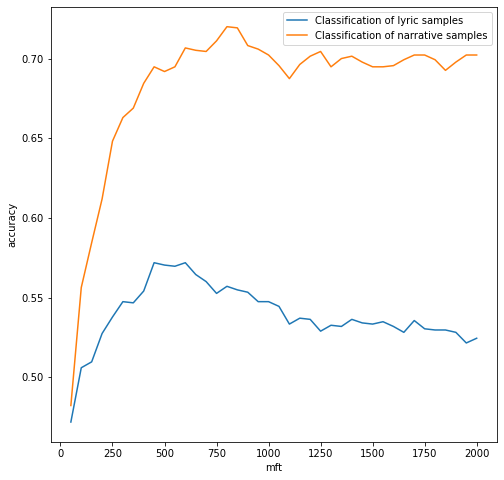

In [6]:
#----------------------------------------------------------------------------------------------------------#
# File contains a list of lyric and narrative poems. It has the same structure as the main data.           #   
# Author names are followed by either L(yric) or N(arrative.                                               #
#----------------------------------------------------------------------------------------------------------#

with open('data/cs_genre.json', 'r') as f:
    data_genre = json.load(f)

mft_levels = [ i*50 for i in range(1,41) ]
iterations = 30
results = defaultdict(lambda: defaultdict(int))   
       
# Perform 30 iterations
for iteration in range(iterations):    

    # Build samples
    s = sticho.Sampler(data_genre, n=100, min_rhymes=0)
    s.level_samples(max_=9)      

    # Iterate over different settings of MFT
    for mft in mft_levels:

        print('iteration #{0} | mft = {1}         '.format(iteration+1, mft), end='\r')     
        
        # Extract features
        f = sticho.Features(s)
        f.bow(domain='lemma', mft=mft)
        f.build_dataframe()
        df = f.df_

        # Reindex dataframe (author, genre)
        authors = df.index.get_level_values(0) 
        df.index = pd.MultiIndex.from_arrays([authors.str[:-1], authors.str[-1:]])
        
        # Perform classification N→L & L→N
        for train_genre, test_genre in (('N', 'L'),('L', 'N')):
            
            # Split dataframe to train and test sets
            train_df = df.loc[(df.index.get_level_values(1) == train_genre)]
            train_X = train_df.values
            train_y = list(train_df.index.get_level_values(0))
            test_df = df.loc[(df.index.get_level_values(1) == test_genre)]
            test_X = test_df.values
            test_y = list(test_df.index.get_level_values(0))
            
            # Train the classifier
            clf = SVC(kernel='linear', C=1)
            clf.fit(train_X, train_y)
            
            # Classify
            predicted = clf.predict(test_X)
            
            # Measure accuracy
            acc = 0
            for a,p in zip(test_y, predicted):
                if a == p:
                    acc += 1
            acc /= len(test_y)
            results[test_genre][mft] += acc/iterations

# Plot the chart
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlabel('mft')
ax.set_ylabel('accuracy')
for genre in sorted(results):
    y = [results[genre][mft] for mft in sorted(results[genre])]
    if genre == 'L':
        label = 'Classification of lyric samples'
    else:
        label = 'Classification of narrative samples'
    ax.plot(mft_levels, y, label=label)   
plt.legend()
plt.show()         